In [78]:
import numpy as np
import emcee
from scipy.optimize import minimize, least_squares, leastsq
from scipy.stats import norm
import matplotlib.pyplot as plt
import corner
from math import factorial

In [2]:
data = np.genfromtxt('D1_c_5.dat')
m=data.shape[0]
x=np.zeros(m)
y=np.zeros(m)
sigma=np.zeros(m)
for i in range(data.shape[0]):
    x[i]=data[i][0]
    y[i]=data[i][1]
    sigma[i] = data[i][2]

In [9]:
def log_prior_uni(a):
    if -100 < a.all() < 100:
        return 0.0
    return -np.inf
    
def log_prior_gauss(a, abar=5):
    gauss = (1 / (np.sqrt(2 * np.pi)*abar)) ** k * np.exp(- a**2 / (2 * abar**2))
    return np.sum(np.log(gauss))

def g(a, x, k):
    g = 0
    for i in range(k+1):
        g += a[i] * x**i
    return g

def chi_squared(a, x, y, sigma):
    return np.sum(((y - g(a, x, k)) / sigma) ** 2)

def log_likelihood(a, x, y, sigma):
    return np.sum(np.log(1 / ( np.sqrt(2 * np.pi) * sigma))) - chi_squared(a, x, y, sigma) / 2
    
def log_posterior_uni(a, x, y, sigma):
    lp_uni = log_prior_uni(a)
    if not np.isfinite(lp_uni):
        return -np.inf
    return lp_uni + log_likelihood(a, x, y, sigma)

def log_posterior_gauss(a, x, y, sigma):
    return log_prior_gauss(a, k) + log_likelihood(a, x, y, sigma)

In [53]:
k = 3     # Order of Taylor_Polynomial, 3 for Corner plots, 4 for correct Fig 3&4

# For Extra task, set k to kmax and exctract terms "a_i" up to order k

fun = lambda *args: -log_likelihood(*args)
initial = np.zeros(k+1) + 0.1 * np.random.randn(k+1)
sol = least_squares(fun, initial, args=(x, y, sigma))

In [12]:
starting_guesses = [sol.x] + 1e-4 * np.random.randn(50, k+1)

nwalkers, ndim = starting_guesses.shape

sampler_uni = emcee.EnsembleSampler(nwalkers, ndim, log_posterior_uni, args=(x, y, sigma))

sampler_uni.run_mcmc(starting_guesses, 5000, progress=True);

100%|█████████████████████████████████████████████████████████| 5000/5000 [00:14<00:00, 339.69it/s]


In [14]:
starting_guesses = np.ones(k+1) + 1e-4 * np.random.randn(50, k+1)

nwalkers, ndim = starting_guesses.shape

sampler_gauss = emcee.EnsembleSampler(nwalkers, ndim, log_posterior_gauss, args=(x, y, sigma))

sampler_gauss.run_mcmc(starting_guesses, 5000, progress=True);

100%|█████████████████████████████████████████████████████████| 5000/5000 [00:16<00:00, 308.38it/s]


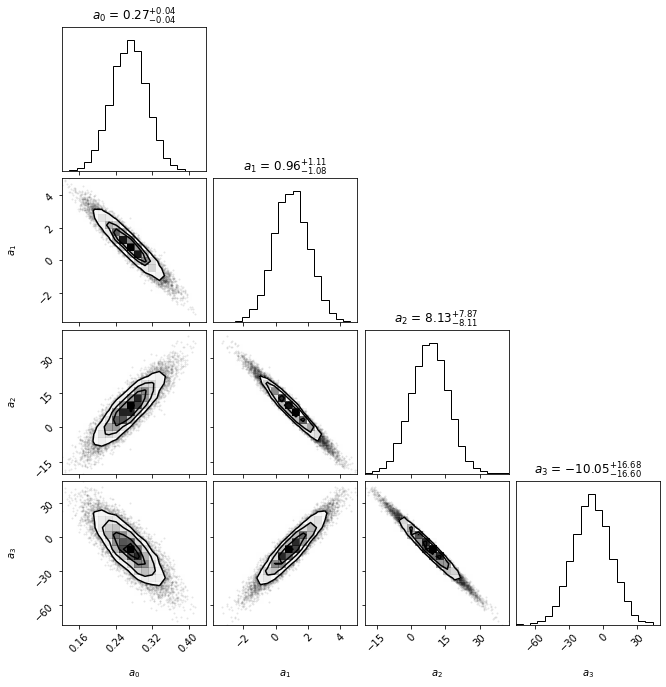

In [16]:
flat_samples_uni = sampler_uni.get_chain(discard=1000, thin=15, flat=True)

labels = [r"$a_0$", r"$a_1$", r"$a_2$", r"$a_3$"]
if k==3:
    fig = corner.corner(flat_samples_uni, labels=labels, titles=labels, show_titles=True);

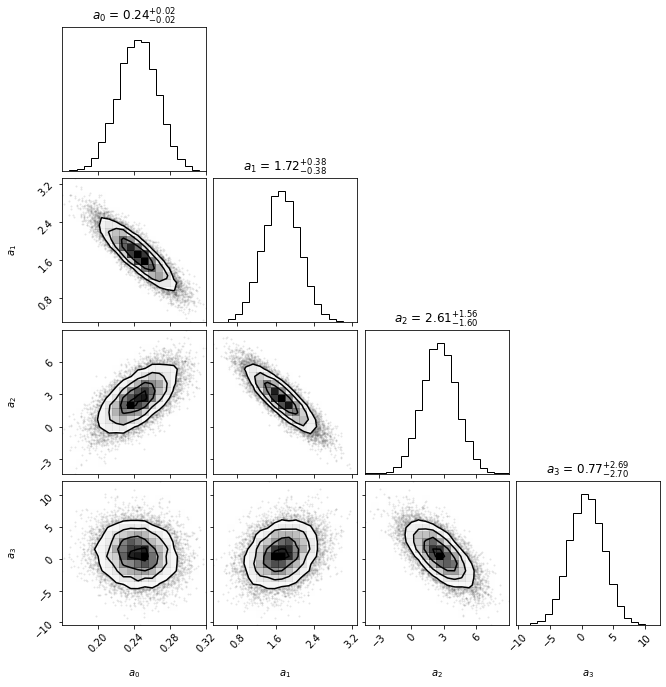

In [17]:
flat_samples_gauss = sampler_gauss.get_chain(discard=1000, thin=15, flat=True)

labels = [r"$a_0$", r"$a_1$", r"$a_2$", r"$a_3$"]
if k==3:    
    fig = corner.corner(flat_samples_gauss, labels=labels, titles=labels, show_titles=True);

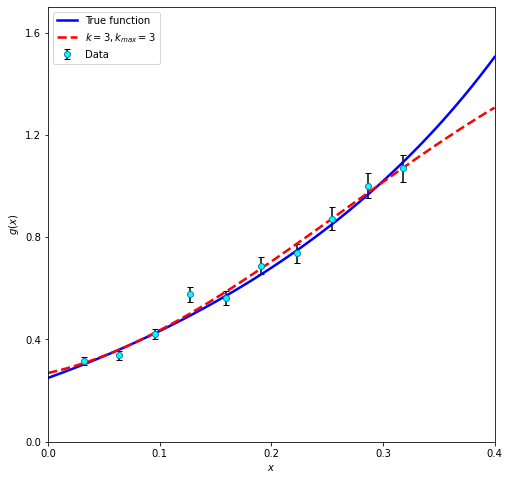

In [18]:
fig = plt.figure(figsize=(8, 8))
plt.errorbar(x, y, (sigma), fmt="o", label="Data", ecolor="black", capsize=3.0, mfc='aqua')
plt.xlim(0.0, 0.4)
plt.xticks(np.linspace(0.0, 0.4, 5))
plt.xlabel(r"$x$")
plt.ylim(0.0, 1.7)
plt.yticks(np.linspace(0.0, 1.6, 5))
plt.ylabel(r"$g(x)$")
x_range = np.linspace(0.0, 0.4, 100)
func = ((1 / 2) + np.tan(np.pi/2 * x_range))**2
plt.plot(x_range, func, label=r"True function", color="b", lw=2.5)
a = sol.x
apprx = g(a, x_range, k)
plt.plot(x_range, apprx, 'r--', label=f"$k={k}, k_"r"{max}="f"{k}$", lw=2.5)
plt.legend(loc='upper left');

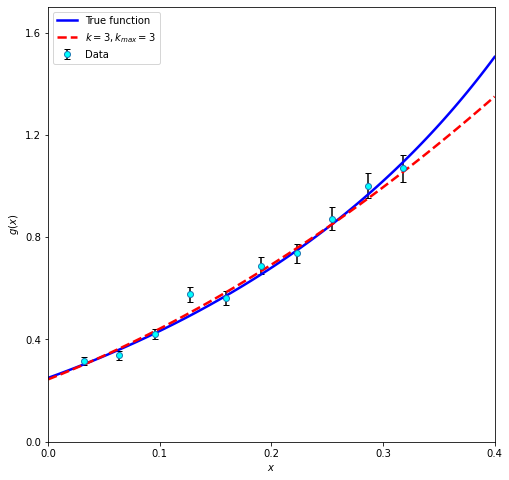

In [19]:
fig = plt.figure(figsize=(8, 8))
plt.errorbar(x, y, (sigma), fmt="o", label="Data", ecolor="black", capsize=3.0, mfc='aqua')
plt.xlim(0.0, 0.4)
plt.xticks(np.linspace(0.0, 0.4, 5))
plt.xlabel(r"$x$")
plt.ylim(0.0, 1.7)
plt.yticks(np.linspace(0.0, 1.6, 5))
plt.ylabel(r"$g(x)$")
x_range = np.linspace(0.0, 0.4, 100)
func = ((1 / 2) + np.tan(np.pi/2 * x_range))**2
plt.plot(x_range, func, label=r"True function", color="b", lw=2.5)
a = np.zeros([k+1, 1])
for i in range(flat_samples_gauss.shape[1]-1):
    a[i] = flat_samples_gauss[:,i].mean()
apprx = g(a, x_range, k)
plt.plot(x_range, apprx, 'r--', label=f"$k={k}, k_"r"{max}="f"{k}$", lw=2.5)
plt.legend(loc='upper left');

In [131]:
for k in range(7):
    fun = lambda *args: chi_squared(*args)
    initial = np.zeros(k+1) + 0.1 * np.random.randn(k+1)
    sol = minimize(fun, initial, args=(x, y, sigma))
    print(sol.x[0:3])
    val = chi_squared(sol.x, x, y, sigma) / (m-1)
    #print(sol.fun / (m-1))

[0.47538448]
[0.20321268 2.55418574]
[0.25028811 1.57276336 3.32892404]
[0.26919836 0.95519809 8.14621624]
[ 0.33266569 -1.88462087 44.68250464]
[  0.56564049 -14.8153773  275.72820765]
[  0.54317687 -13.37150575 243.37192198]


In [138]:
for k in range(7):
    starting_guesses = np.ones(k+1) + 1e-4 * np.random.randn(50, k+1)
    nwalkers, ndim = starting_guesses.shape
    sampler_gauss = emcee.EnsembleSampler(nwalkers, ndim, log_posterior_gauss, args=(x, y, sigma))
    sampler_gauss.run_mcmc(starting_guesses, 1000, progress=True);
    flat_samples_gauss = sampler_gauss.get_chain(discard=100, thin=15, flat=True)
    for i in range(flat_samples_gauss.shape[1]-1):
        a = np.zeros([1, k+1])
        a[i] = flat_samples_gauss[:,i].mean()
    
# DETHÄR SUGER!

/Users/victorgustafsson/miniconda3/envs/tif285-env/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  import sys
/Users/victorgustafsson/miniconda3/envs/tif285-env/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/Users/victorgustafsson/miniconda3/envs/tif285-env/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
100%|█████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 331.54it/s]


0.20623686250408954


100%|█████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 369.73it/s]


[[0.20650098 0.20650098]]


100%|█████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 346.87it/s]


IndexError: index 1 is out of bounds for axis 0 with size 1